<a href="https://colab.research.google.com/github/sametgirgin/Hibrit-Enerji-Sistemi/blob/main/Yenilenebilir_Enerjiyle_%C5%9Eebeke_Optimizasyonu_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Makine Öğrenimi Algoritmalarıyla Şebeke Talep & Üretim Tahmini, Optimizasyonu ve Çevre-Ekonomik Etki Değerlendirmesi:**



Akıllı şehir, kamu hizmetlerini iyileştirmek, kentsel zorluklara çözüm bulmak ve sakinlerinin yaşam kalitesini artırmak için teknoloji ve verileri kullanan bir şehirdir.

**Bu, trafik akışını optimize etmek, enerji kullanımını yönetmek, kamu güvenliğini artırmak ve daha fazlasını yapmak için sensörlerin ve veri analitiğinin kullanılmasını içerebilir. **

Bu çalışma, enerji modellerini belirlemek, talebi ve yenilenebilir üretimi tahmin etmek ve güvenilir şebeke yönetimi için optimizasyon stratejileri tasarlamak amacıyla geçmiş veri analizi için Python'un kullanılmasına odaklanmaktadır.

Amaç, hem çevresel hem de ekonomik etkileri değerlendirerek yenilenebilir enerji kullanımını en üst düzeye çıkarırken şebeke istikrarını iyileştirmektir.

Adımlar ve Çıktılar:

1-Veri Analizi:

- Geçiş veriler talep ve arzdaki desenleri (patern) bulmak için analiz edilir. (Güneş ve rüzgardaki reliability ve variability önemli)

- Hava durumu ve yenilenebilir enerji arasındaki korelasyona bakılır

2- Tahminleme:

- Gelecek 7 günü tahminleyen bir ML modeli oluşturulur

- Geçmiş hava durumu verilerine dayanarak güneş ve rüzgar enerjisi üretimini tahmin edilir. Model performansını değerlendirmek için RMSE (Root Mean Square Error) kullanılır.

3- Optimizasyon Stratejisi:
- Üretilen elektrik maliyetini minimize eden bir optimazasyon sorunu çözülür.

4- Etki değerlendirmesi:

- Optimizasyon stratejisiyle elde edilecek karbon emisyonlarındaki azalma ölçülür. (Doğal gaz için 0,5 kg CO2/kWh).

- Pik yük enerji santrallerine olan bağımlılığın azalması ve yenilenebilir enerji kullanımının artmasıyla elde edilen tasarrufları hesaplayarak ekonomik etki değerlendirilir.

- Maliyetler:

  - Güneş enerjisi için 0,05 $/kWh

  - Rüzgar için 0,07 $/kWh

  - Doğal gaz için 0,15 $/kWh


In [ ]:
!pip install pulp

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pulp
# Veri kümeleri yüklenir

weather_data = pd.read_csv("https://raw.githubusercontent.com/sametgirgin/Hibrit-Enerji-Sistemi/main/WeatherData.csv")
energy_data = pd.read_csv("https://raw.githubusercontent.com/sametgirgin/Hibrit-Enerji-Sistemi/main/EnergyData.csv")

In [ ]:
# Veri tablolarına ön gözlem
print(energy_data.head())
print(weather_data.head())

       Date  Hour  Demand_MW  Solar_MW    Wind_MW
0  1/1/2023     0  85.488436       0.0  16.640621
1  1/1/2023     1  85.212058       0.0  16.452806
2  1/1/2023     2  85.662402       0.0  16.452806
3  1/1/2023     3  86.015495       0.0  16.596152
4  1/1/2023     4  88.713942       0.0  16.855640
         Date  AvgTemp_Celsius  SunlightHours  AvgWindSpeed_kmh
0  2023-01-01        12.760438       9.191722         18.239061
1  2023-01-01        12.760438       9.191722         18.239061
2  2023-01-01        12.760438       9.191722         18.239061
3  2023-01-01        12.760438       9.191722         18.239061
4  2023-01-01        12.760438       9.191722         18.239061


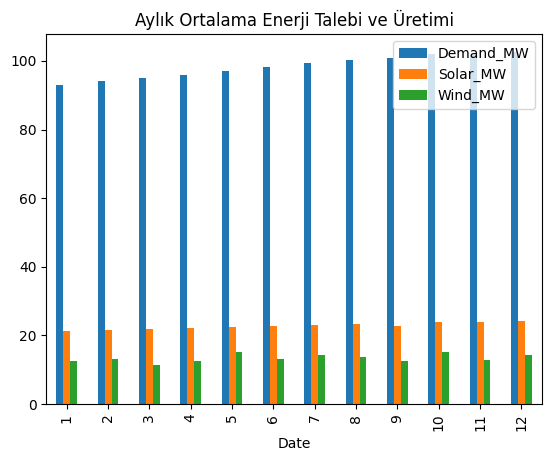

In [ ]:
# Aylık enerji talebi ve üretimlerinin ortalamaları
energy_data["Date"] = pd.to_datetime(energy_data["Date"])
energy_data.set_index('Date', inplace=True)
energy_data.groupby(energy_data.index.month).mean().plot(kind='bar', y=['Demand_MW', 'Solar_MW', 'Wind_MW'])
plt.title('Aylık Ortalama Enerji Talebi ve Üretimi')
plt.show()

Verisetlerinin birleşitirilmesi ve Korelasyon Analizi

<Axes: >

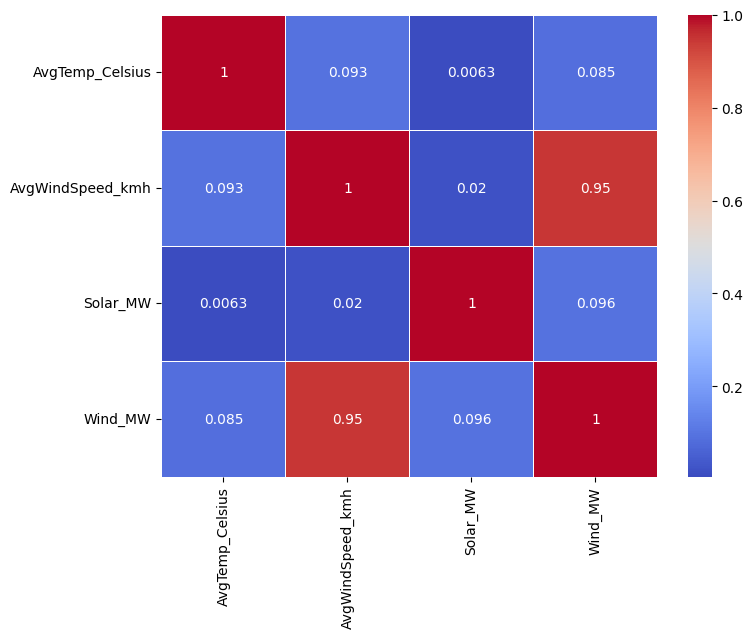

In [ ]:
# Birleştirme işlemi için indeks silme
energy_data.reset_index(inplace=True)
# Tarih sütunları Datetime formatında
weather_data['Date'] = pd.to_datetime(weather_data['Date'])
# İki veris seti tarihlerden birleştirildi
merged_data = pd.merge(energy_data, weather_data, on='Date')
# Güneşte bazı günler 0 alınıdığı için bunlar filtrelenir.
merged_data = merged_data[merged_data['Solar_MW'] > 0]

# Enerji üretimi ve hava durumu korelasyonu
correlation = merged_data[['AvgTemp_Celsius', 'AvgWindSpeed_kmh','Solar_MW', 'Wind_MW']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm',linewidths=.5)

Enerji Üretim ve Talebini Tahmini

https://en.wikipedia.org/wiki/Root_mean_square_deviation
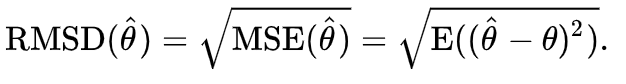

In [ ]:
# Tahmin kurulumu (y Hedef değişkenler, X özellikler)
X = merged_data[['AvgTemp_Celsius', 'AvgWindSpeed_kmh' ]]
y_demand = merged_data['Demand_MW']
y_solar = merged_data['Solar_MW']
y_wind = merged_data['Wind_MW']

# Enerji Talebi için eğitim ve test verisi oluşturma, model eğitme ve tahminleme
X_train, X_test, y_train, y_test = train_test_split(X, y_demand, test_size=0.2, random_state = 42)
demand_model = RandomForestRegressor(random_state=42)
demand_model.fit(X_train, y_train)
y_pred_demand = demand_model.predict(X_test)

# Güzel ve rüzgar modeli kurulumu- Rüzgar ve güneş için iki ayrı model örneği oluşturulur.
solar_model = RandomForestRegressor(random_state=42)
wind_model = RandomForestRegressor(random_state=42)

# Sıfır güneş enerjisi üretimini filtreledikten sonra endekslerin hizalanması gereklidir
X = X.reset_index(drop=True)
y_solar = y_solar.reset_index(drop=True)
y_wind = y_wind.reset_index(drop=True)

# Güneş ve rüzgar enerjisi için eğitim ve test verisi oluşturma, model eğitme ve tahminleme
X_train_solar, X_test_solar, y_train_solar, y_test_solar =  train_test_split(X, y_solar, test_size=0.2, random_state=42)
X_train_wind, X_test_wind, y_train_wind, y_test_wind = train_test_split(X, y_wind, test_size=0.2, random_state=42)
solar_model.fit(X_train_solar, y_train_solar)
wind_model.fit(X_train_wind, y_train_wind)
y_pred_solar = solar_model.predict(X_test_solar)
y_pred_wind = wind_model.predict(X_test_wind)

# Gerçek değeri sıfır olan tahmin değerlerini düzeltmek için sıfır değeri girilir.
actual_zeros = energy_data[energy_data['Solar_MW']== 0].index
mask_zeros_in_actuals = X_test_solar.index.isin(actual_zeros)
y_pred_solar_corrected = np.where(mask_zeros_in_actuals, 0, y_pred_solar)

#Model değerlendirme süreci
# Gerçek ve tahmini değerlerden elde edilen RMSE değerini tanımlayan fonksiyorn yazılır.
def rmse_percentage(true_values, predicted_values):
  rmse = sqrt(mean_squared_error(true_values, predicted_values))
  average = np.mean(true_values)
  return (rmse / average)*100

# Enerji Talebi, güneş ve rüzgar enerji üretimleri için RMSE hesabu
demand_rmse = rmse_percentage (y_test, y_pred_demand)
solar_rmse = rmse_percentage (y_test_solar, y_pred_solar)
wind_rmse = rmse_percentage (y_test_wind, y_pred_wind)

# RMSE yüzdesi çıktıları
print (f"Demand Forecast RMSE (%): {demand_rmse}")
print (f"Solar Production Forecast RMSE (%): {solar_rmse}")
print(f"Wind Production Forecast RMSE (%): {wind_rmse}")

Demand Forecast RMSE (%): 5.943996634938721
Solar Production Forecast RMSE (%): 9.011440280631595
Wind Production Forecast RMSE (%): 8.31763762351461


Tahmin edilen değerlerin ve Gerçek Değerlerin Görselleştirilmesi:

- Modelin enerji gereksinimlerini, güneş ve rüzgar üretimlerini tahminde doğruluğunu (accuracy) anlamak

- (Solar için) Bu grafikler, modelin güneş ışığı mevcudiyeti ve hava koşulları gibi faktörlerden etkilenen güneş enerjisi üretimindeki doğal değişkenliği ele alma yeteneğini değerlendirmek için önemlidir.


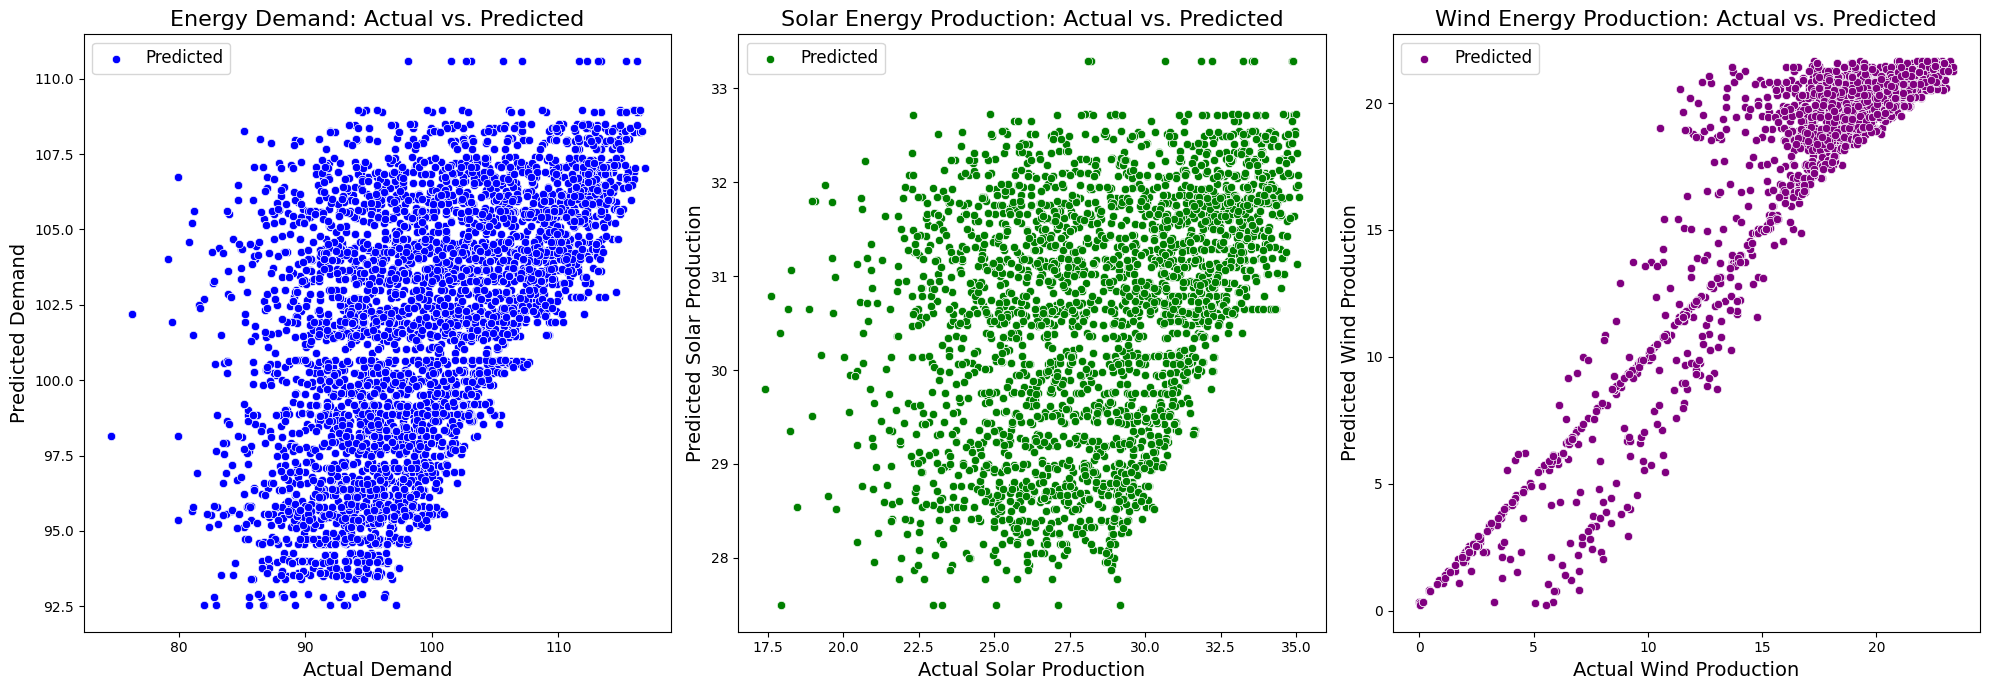

In [ ]:
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(20, 7))

# Enerji talep görselleştirmesi
sns.scatterplot(x=y_test, y=y_pred_demand, color='blue', label='Predicted', ax=axes[0])
axes[0].set_title('Energy Demand: Actual vs. Predicted', fontsize=16)
axes[0].set_xlabel('Actual Demand', fontsize=14)
axes[0].set_ylabel('Predicted Demand', fontsize=14)
axes[0].legend(fontsize=12)

# Güneş enerji üretimi görselleştirmesi
sns.scatterplot(x=y_test_solar, y=y_pred_solar, color='green', label='Predicted', ax=axes[1])
axes[1].set_title('Solar Energy Production: Actual vs. Predicted', fontsize=16)
axes[1].set_xlabel('Actual Solar Production', fontsize=14)
axes[1].set_ylabel('Predicted Solar Production', fontsize=14)
axes[1].legend(fontsize=12)

# Rüzgar enerji üretimi görselleştirmesi
sns.scatterplot(x=y_test_wind, y=y_pred_wind, color='purple', label='Predicted', ax=axes[2])
axes[2].set_title('Wind Energy Production: Actual vs. Predicted', fontsize=16)
axes[2].set_xlabel('Actual Wind Production', fontsize=14)
axes[2].set_ylabel('Predicted Wind Production', fontsize=14)
axes[2].legend(fontsize=12)

plt.tight_layout()
plt.show()

SARIMAX ile Günlük Enerji Tahmini


- Bu bölüm günlük enerji tahmini için SARIMAX (Seasonal AutoRegressive Integrated Moving Average) modelini kullanır.

- SARIMAX zaman serilerinde hem mevsimsel hem de mevsimsel olmayan bileşenleri modelleyebilir. Bu sayade daha kompleks patternlar yakalanabilir ve enerji yönetiminde önemli olan tahminin doğruluğu daha iyi sağlanmış olur.  


https://towardsdatascience.com/time-series-forecasting-with-arima-sarima-and-sarimax-ee61099e78f6

https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html


- energy_data zaman serisi analizine hazırlamak için günlük bir zaman serisine dönüştürülür. (Günlük ortalama hesabı)

- SARIMAX modeli, serinin hem mevsimsel olmayan hem de mevsimsel kısımları için otoregresif, fark alma ve hareketli ortalama bileşenleri de dahil olmak üzere modelin yapısını tanımlayan belirli parametrelerle (order ve seasonal_order) yapılandırılmıştır. season_order parametresi, enerji talebi verilerinde yaygın olan haftalık mevsimselliği modellemek için 7 günlük bir periyodu içerir.






In [ ]:
# SARIMAX ile günlük enerji talep tahmini
energy_data_daily = energy_data.set_index('Date').resample('D').mean()
sarima_model = SARIMAX( energy_data_daily['Demand_MW'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 7) )
sarima_results = sarima_model.fit(disp=False)
sarima_forecast = sarima_results.forecast(steps=7)
print("Sonraki 7 gün için SARIMAX modeli: ")
print(sarima_forecast)

Sonraki 7 gün için SARIMAX modeli: 
2024-01-01    101.253215
2024-01-02    102.083820
2024-01-03    101.868729
2024-01-04    102.082013
2024-01-05    102.392957
2024-01-06    102.757862
2024-01-07    101.833041
Freq: D, Name: predicted_mean, dtype: float64


PuLP ile Optimizasyon: (Kaynak: https://coin-or.github.io/pulp/)

Ortalama günlük enerji talebini minimum maliyetle karşılamak için güneş, rüzgar ve şebeke tedarikinin en uygun karışımını belirlemek için bir optimizasyon problemi için, bir doğrusal programlama kütüphanesi olan PuLP kullanılabilir.

https://towardsdatascience.com/introduction-to-linear-programming-in-python-9261e7eb44b


- Tahmin sonuçlarından **ortalama güneş ve rüzgar üretimi ve talep hesabı** yapılır. Bu adım tedarik gereksinimini ve dolayısıyla optimizasyon modelinin neyi başarmayı amaçladığına ilişkin temeli belirler.

- **Karar Değişkenleri**: Modelde karar değişkenleri bulmak istediğimiz değerlerdir. Burada, sebeke_tedarik, gunes_tedarik ve rüzgar_tedarik karar değişkenleri her bir kaynaktan tedarik edilecek enerji miktarını verir.

* Güneş ve rüzgar kaynakları, çözümlerin gerçekçi olması ve tahmin edilen potansiyel enerji üretimini aşmamasını sağlamak için belirlenen ortalama üretim kapasiteleriyle sınırlıdır.

- **Amaç Fonksiyonu**: Optimizasyon probleminin ana unsurudur. Burada, hedefimiz enerji tedarik maliyetini minimize etmektir. Bu fonksiyon güneş, rüzgar ve şebekeden sağlanan (doğalgaz kaynaklı elektrik) için kWh başına maliyetleri içerir. Bu fonksiyon minimize edilerek, talebin en düşük maliyette sağlanması amaçlanmaktadır.

* **Kısıtlamalar**: Optimizasyon probleminin çözümünün uyması gerektiği kurallarıdır. Buradaki ana kısıtlama, güneşten, rüzgardan ve şebekeden sağlanan toplam enerjinin en azından ortalama günlük talebe eşit olmasıdır.

* **Çözüm ve Çıktı**: Her bir enerji kaynağı için optimum besleme miktarlarını çıktı olarak verir uygun bir çözüm bulamazsa kullanıcıyı uyarır.


* **Emisyon ve Ekonomik Etki Değerlendirme**:  Şebeke tedariği yerine yenilenebilir enerji kaynakları sayesinde CO2 emisyon azalımı ve ekonomik tasarruf miktarı.

In [ ]:
# PuLP ile optimizasyon
avg_solar_production_MWh_corrected = np.mean(y_pred_solar_corrected)
avg_wind_production_MWh = np.mean(y_pred_wind)
avg_daily_demand_MW = np.mean(y_pred_demand)

# Etki değerlendirme için sabitler
sebeke_emisyon_faktoru = 0.5
gunes_maliyeti_per_kWh = 0.05
ruzgar_maliyeti_per_kWh = 0.07
gaz_maliyeti_per_kWh = 0.15

# Optimizasyon problemini belirle
problem = pulp.LpProblem("Enerji_Optimizasyonu", pulp.LpMinimize)

# Düzeltilmiş güneş üretimi kullanımı için tedarik değişkenlerinin güncellenmesi
sebeke_tedarik = pulp.LpVariable("Şebeke_Tedarik", lowBound=0)
gunes_tedarik = pulp.LpVariable("Güneş_Tedarik", lowBound=0,upBound=avg_solar_production_MWh_corrected)
ruzgar_tedarik = pulp.LpVariable("Rüzgar_Tedarik",lowBound=0, upBound=avg_wind_production_MWh)

# Amaç Fonksiyonu
problem += (gunes_maliyeti_per_kWh * gunes_tedarik + ruzgar_maliyeti_per_kWh* ruzgar_tedarik + gaz_maliyeti_per_kWh*sebeke_tedarik, "Total Cost")
problem += (sebeke_tedarik + gunes_tedarik + ruzgar_tedarik >= avg_daily_demand_MW,"Talep Karşılama")
problem.solve()
# Optimum tedarikte Çözüm ve Çıktı
if pulp.LpStatus[problem.status] == 'Optimal':
  print(f"Optimum şebeke tedariği: {sebeke_tedarik.varValue} MW")
  print (f"Optimum solar tedariği: {gunes_tedarik.varValue} MW")
  print(f"Optimum rüzgar tedariği: {ruzgar_tedarik.varValue} MW")
else:
  print("Optimizasyon ekonomik bir çözüm bulamadı")

# Emisyon Etki Değerlendirmesi
emisyon_azaltma_kg = (gunes_tedarik.varValue + ruzgar_tedarik.varValue) * sebeke_emisyon_faktoru
gaz_maliyeti = avg_daily_demand_MW * gaz_maliyeti_per_kWh
optimizasyonlu_maliyet = pulp.value(problem.objective)
tasarruf = gaz_maliyeti - optimizasyonlu_maliyet

print(f"Emisyon azalımı: {emisyon_azaltma_kg} kg CO2")
print (f"Ekonomik Tasarruf: ${tasarruf}")

Optimum şebeke tedariği: 57.638428 MW
Optimum solar tedariği: 29.993019 MW
Optimum rüzgar tedariği: 13.626215 MW
Emisyon azalımı: 21.809617 kg CO2
Ekonomik Tasarruf: $4.089399168112882


**Enerji Tedarik Dağılımının ve Çevre-Ekonomik Etkilerin  Görselleştirilmesi:**



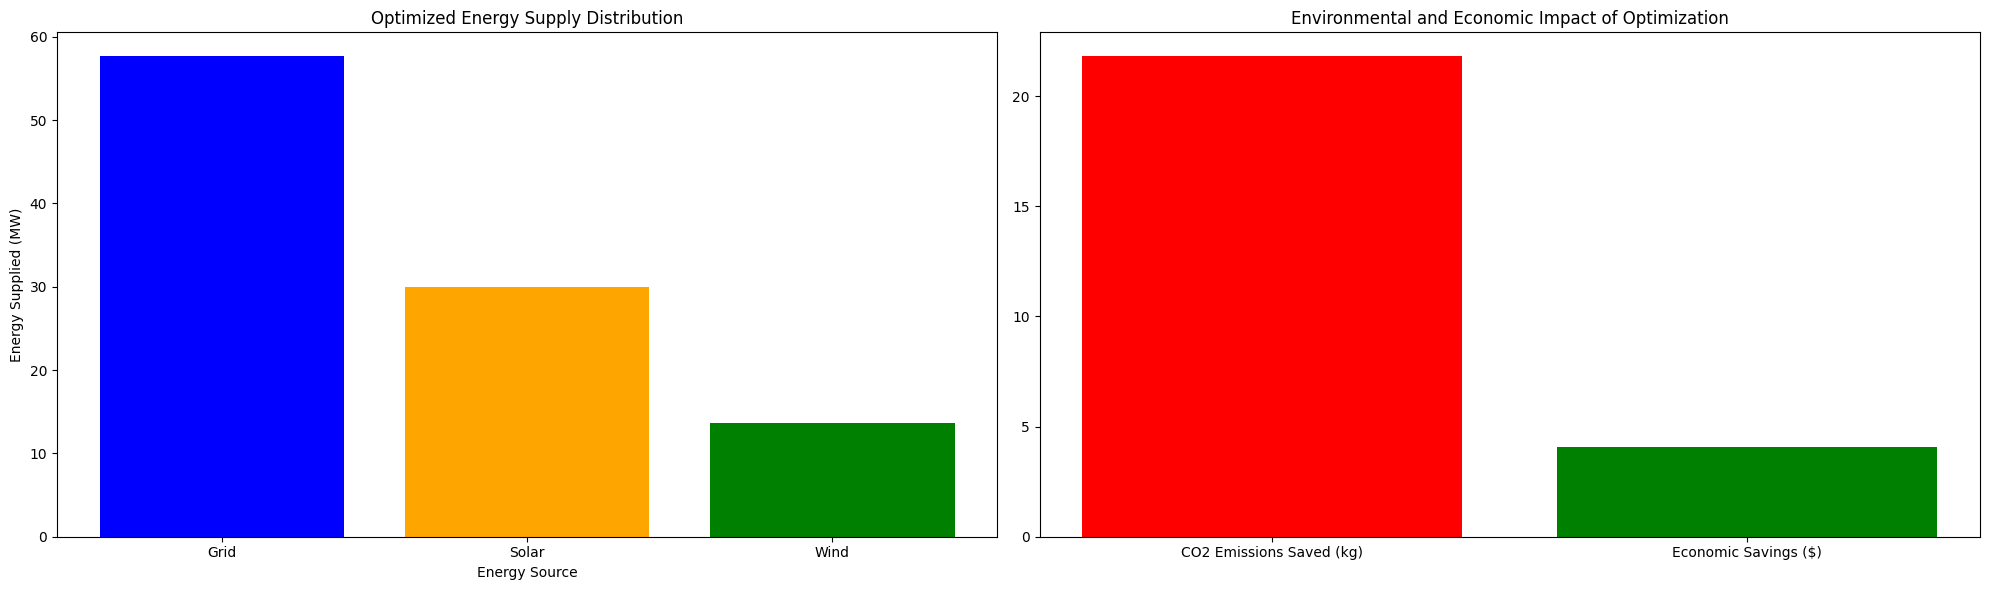

In [ ]:
# Set up subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Visualization 1: Optimized Energy Supply Distribution
axes[0].bar(['Grid', 'Solar', 'Wind'], [grid_supply.varValue, solar_supply.varValue, wind_supply.varValue], color=['blue', 'orange', 'green'])
axes[0].set_title('Optimized Energy Supply Distribution')
axes[0].set_xlabel('Energy Source')
axes[0].set_ylabel('Energy Supplied (MW)')

# Visualization 2: Environmental and Economic Impact of Optimization
axes[1].bar(['CO2 Emissions Saved (kg)', 'Economic Savings ($)'], [emissions_saved_kg, savings], color=['red', 'green'])
axes[1].set_title('Environmental and Economic Impact of Optimization')

plt.tight_layout()
plt.show()